### Autoencoder
Il primo modello creato è l'autoencoder e usa gli stessi principi delle CNN per creare una rappresentazione compatta delle immagini. Infatti il modello è composto da dei Convolutional Layer che, riducono la dimensione spaziale per aumentare la dimensionde dei filtri.\
L'encoder ha inoltre dei layer di BatchNormalization.

Questo modello è quello più lungo da addestrare solamente perchè ha abbastanza parametri e il dataset, essendo grande, non ci sta in memoria.\
Per queste ragioni la batch è piccola e generata da una funzione.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models, callbacks

dataset_path = '../../datasets/covid_cxr_cache.npy'
model_save_path = '../../models/autoencoder.keras'

latent_space = 128
epochs = 50
batch = 32

Qui carichiamo il dataset e il modello dalla classe creata apposta. Il modello preso sarà caricato o da file (e quindi non verrà addestrato) oppure viene costruito e poi addestrato.

In [2]:
dataset = np.load(dataset_path, allow_pickle=True).item()

(x_train, _) = dataset['train']
(x_val, _) = dataset['val']
(x_test, _) = dataset['test']

shape = x_train.shape[1:]

La struttura dell'autoencoder.\
Il modello verrà valutato tramite *MSE* dato che i valori dei pixel saranno compresi tra \[0,1\]

In [3]:
in_encoder = layers.Input(shape=shape, dtype='float32')
x = layers.BatchNormalization()(in_encoder)
x = layers.Conv2D(32, 3, padding='same', strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(64, 3, padding='same', strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 3, padding='same', strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 3, padding='same', strides=2)(x)
x = layers.BatchNormalization()(x)
before_flatten = x.shape[1:]
x = layers.Flatten()(x)
flatten = x.shape[1]
x = layers.LeakyReLU()(x)
latent = layers.Dense(latent_space, activation='sigmoid')(x)
encoder = models.Model(in_encoder, latent, name='encoder')

in_decoder = layers.Input(shape=(latent_space,))
x = layers.Dense(flatten)(in_decoder)
x = layers.LeakyReLU()(x)
x = layers.Reshape(before_flatten)(x)
x = layers.Conv2DTranspose(256, 3, padding='same', strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(128, 3, padding='same', strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(64, 3, padding='same', strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(32, 3, padding='same', strides=2)(x)
x = layers.LeakyReLU()(x)
out_decoder = layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)
decoder = models.Model(in_decoder, out_decoder, name='decoder')

in_autoencoder = layers.Input(shape=shape)
encoder_out = encoder(in_autoencoder)
decoder_out = decoder(encoder_out)
autoencoder = models.Model(in_autoencoder, decoder_out, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 128)            │     6,812,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 224, 224, 1)    │     7,450,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,262,789 (54.41 MB)

 Trainable params: 14,261,827 (54.40 MB)

 Non-trainable params: 962 (3.76 KB)

In questa porzione di codice il modello viene addestrato

In [4]:
def data_generator(x, batch_size):
    indices = np.arange(len(x))
    while True:
        np.random.shuffle(indices)
        for i in range(0, len(x), batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_data = x[batch_indices].astype('float32') / 255.0
            yield batch_data, batch_data

batch_steps = len(x_train) // batch + 1
batch_val_steps = len(x_val) // batch + 1
gen_train = data_generator(x_train, batch)
gen_val = data_generator(x_val, batch)

history = autoencoder.fit(gen_train, validation_data=gen_val,
                          epochs=epochs,
                          steps_per_epoch=batch_steps, validation_steps=batch_val_steps,
                          callbacks=[callbacks.ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss', mode='min')])


Epoch 1/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 206s 90ms/step - loss: 0.0172 - val_loss: 0.0127
Epoch 2/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 197s 87ms/step - loss: 0.0100 - val_loss: 0.0098
Epoch 3/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 193s 90ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 4/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 184s 87ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 5/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 184s 87ms/step - loss: 0.0083 - val_loss: 0.0086
Epoch 6/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 179s 85ms/step - loss: 0.0081 - val_loss: 0.0089
Epoch 7/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 183s 86ms/step - loss: 0.0078 - val_loss: 0.0079
Epoch 8/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 182s 86ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 9/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 178s 84ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 10/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 178s 84ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 11/50
2120/2120 ━━━━━━━━━━━━━━━━━━━━ 178s 84ms/step - loss: 0.0074 - val_loss: 0.00

Di seguito viene mostrato il valore e il grafico della loss per il modello dell'autoencoder.

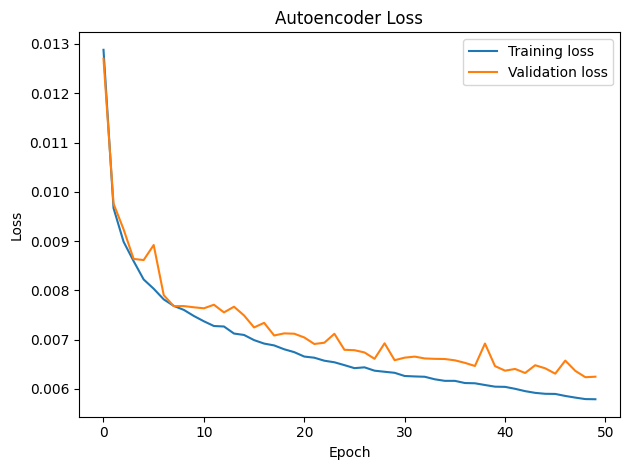

In [5]:
plt.figure(figsize=None)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title(f'Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Di seguto vengono presi 10 casi di test, mostrati e ricostruiti

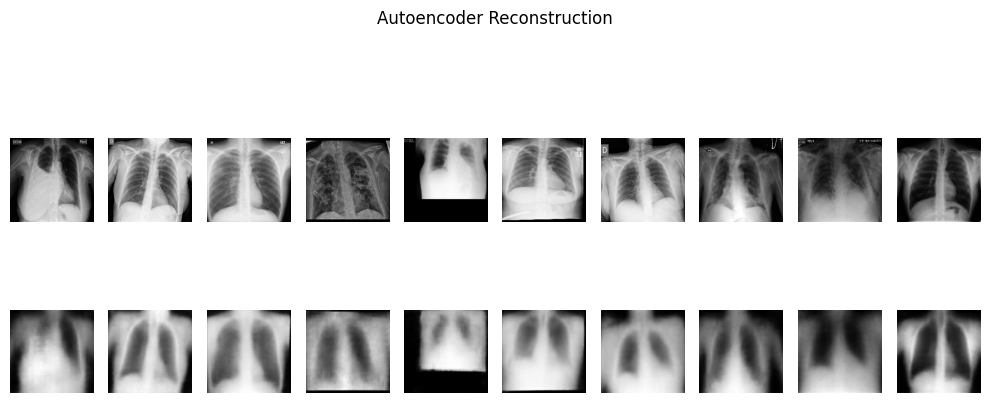

: 

In [ ]:
autoencoder = models.load_model(model_save_path)

total_rand = 10
rand_indices = np.random.choice(len(x_test), total_rand, replace=False)

x_test_rand = x_test[rand_indices] / 255.0
x_test_reconstructed = autoencoder.predict(x_test_rand, verbose=0)

plt.figure(figsize=(10, 5))
for i in range(total_rand):
    plt.subplot(2, total_rand, i + 1)
    plt.imshow(x_test_rand[i].reshape(shape), cmap='gray')
    plt.axis('off')
    plt.subplot(2, total_rand, i + 1 + total_rand)
    plt.imshow(x_test_reconstructed[i].reshape(shape), cmap='gray')
    plt.axis('off')
plt.suptitle('Autoencoder Reconstruction')
plt.tight_layout()
plt.show()